# Hypothetical Document Embedding (HyDE) Query Transform using LlamaIndex

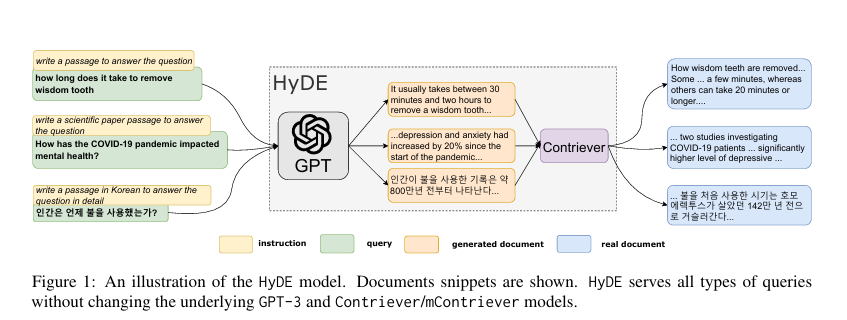

## **Hypothetical Document Embeddings (HyDE)** <br>
A method that transforms documents into vector representations, or embeddings, using two main components.
### 1. Generative task:
  - Employs large language model to generate a hypothetical document that could answer the user's query.
  - The generated document does not have to be accurate or factually correct — it only needs to capture what kind of information would be relevant to the query.
  - Basically, "If someone asked this question, what kind of answer might they expect?"
  - Helps to bring in context, related terms to the query and reflects the semantics of what the user wants

### 2. Document-document similarity task:
  - Once the hypothetical document is generated, we encode it into a dense vector embedding: Contrastive encoder(OpenAI embeddings, BERT, etc.)
  - The encoder compresses the document into an embedding and filters out hallucinated details only leaving key semantic features.
  - The resulting vector is compared against the document embeddings in the vector store

## Why is this better than directly embedding queries?
- Queries are often short, sparse, and ambiguous.
- Directly embedding queries sometimes fails to capture enough semantic signal to retrieve relevant documents.
- HyDE expands the query into a richer, more detailed pseudo-document, giving the retrieval system much more to work with.

## Results
- Outperforms Contriever (which was state-of-the-art unsupervised retriever)
- Comparable to fine-tuned retrievers on many tasks.
- Works well cross-lingually and in low-resource settings.


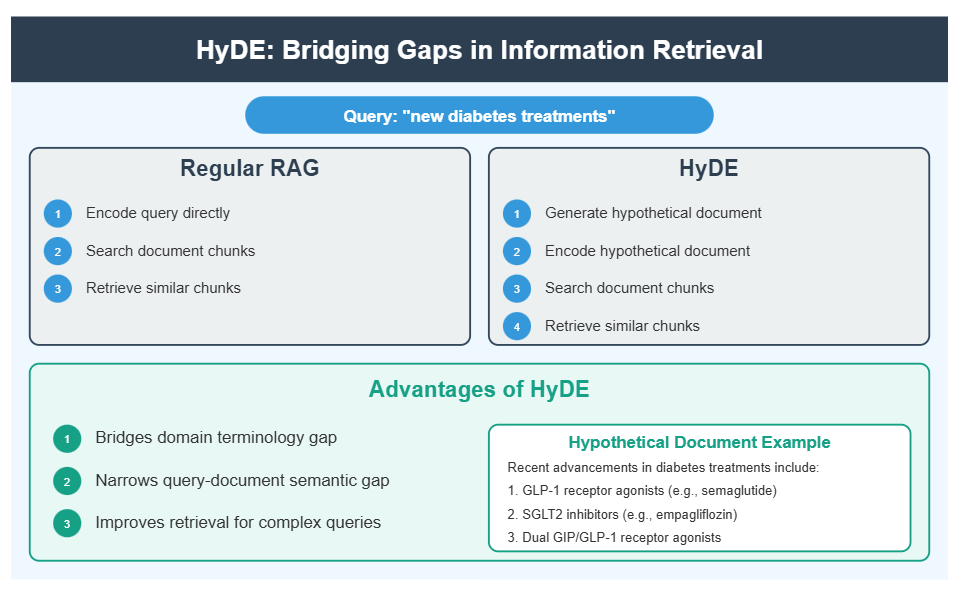

## Method

This notebook demonstrates how to implement **HyDE (Hypothetical Document Embeddings)** based query transformation to enhance the retrieval process in Retrieval-Augmented Generation (RAG) pipelines.


## Implementation Steps
**1. Prepare Your Data<br>**
- Load your documents using SimpleDirectoryReader or another data loader.
- Split documents into sentences for finer granularity with SentenceSplitter.

**2. Set Up the LLM and Embeddings<br>**
- Initialize a language model (e.g., Cohere) for hypothetical document generation.
- Initialize an embedding model (e.g., CohereEmbedding) for encoding.

**3. Build the Vector Index<br>**
- Use VectorStoreIndex to index your document embeddings.

**4. Apply HyDE Query Transform<br>**
- Create a HyDEQueryTransform instance to generate hypothetical documents from queries.
- Wrap your query engine with TransformQueryEngine to apply the HyDE transformation at query time.

**5. Run Retrieval<br>**
- Input a query; the pipeline generates a hypothetical document, encodes it, and retrieves semantically similar documents from the index.

<b>This notebook uses:
- Cohere API
- LlamaIndex (for indexing and querying)</b>


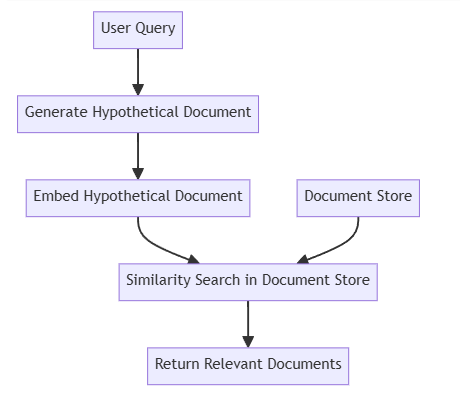

Resources used:
1. https://arxiv.org/pdf/2212.10496
2. https://docs.llamaindex.ai/en/stable/optimizing/advanced_retrieval/query_transformations/
3. https://teetracker.medium.com/rag-with-hypothetical-document-embeddings-hyde-0edeca23f891
4. https://docs.llamaindex.ai/en/stable/examples/query_transformations/HyDEQueryTransformDemo/

## Installing Dependencies

In [ ]:
!pip install llama-index llama-index-llms-cohere llama-index-embeddings-cohere

Importing necessary libraries

In [5]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))


from IPython.display import Markdown, display
import os
from llama_index.core.node_parser import SentenceSplitter
from llama_index.llms.cohere import Cohere
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, PromptTemplate
from llama_index.core.indices.query.query_transform.base import (HyDEQueryTransform,)
from llama_index.core.query_engine import TransformQueryEngine



Set up API key as environment variable

In [6]:
from google.colab import userdata
import os
os.environ["COHERE_API_KEY"] = userdata.get('COHERE_API_KEY')

### Download Data

In [7]:
!mkdir -p 'data/paul_graham/'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/paul_graham/paul_graham_essay.txt' -O 'data/paul_graham/paul_graham_essay.txt'

--2025-06-20 05:55:06--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/paul_graham/paul_graham_essay.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75042 (73K) [text/plain]
Saving to: ‘data/paul_graham/paul_graham_essay.txt’

data/paul_graham/pa 100%[===================>]  73.28K  --.-KB/s    in 0.02s   

2025-06-20 05:55:06 (3.21 MB/s) - ‘data/paul_graham/paul_graham_essay.txt’ saved [75042/75042]



## Load documents, build the VectorStoreIndex

In [8]:
# load documents
documents = SimpleDirectoryReader("./data/paul_graham/").load_data()

In [ ]:
# Load VectorStoreIndex by selecting the splitter(chunk_size, chunk_overlap) and embedded model directly
embed_model = CohereEmbedding(
    api_key=os.environ["COHERE_API_KEY"],
    model_name="embed-english-v3.0"
)

node_parser = SentenceSplitter(chunk_size=500, chunk_overlap=100)
nodes = node_parser.get_nodes_from_documents(documents)
index = VectorStoreIndex(nodes, embed_model=embed_model, show_progress=True)

# Usage Examples

## Example 1: HyDE improves specific temporal queries

In [88]:
query_str = "what did paul graham do after going to RISD"

#### First, we query without transformation: The same query string is used for embedding lookup and also summarization.

In [86]:
base_retriever = index.as_retriever(similarity_top_k=5)
from llama_index.llms.cohere import Cohere

llm = Cohere(
    model="command-r",
    temperature=0.2,
    api_key=os.environ["COHERE_API_KEY"],
    max_tokens=512,)

query_engine = index.as_query_engine(
  streaming=True,
  similarity_top_k=3,
  llm=llm)

In [89]:
response = query_engine.query(query_str)
display(Markdown(f"<b>{response}</b>"))

<b>After attending RISD (Rhode Island School of Design), Paul Graham went back to doing his PhD in computer science. He was still in love with coding and simultaneously working on his art. This dual interest led him to the idea that became ViaWeb, a company that created web applications.</b>

#### Now, we use `HyDEQueryTransform` to generate a hypothetical document and use it for embedding lookup.

In [90]:
# HyDE Query Transform
hyde = HyDEQueryTransform(include_original=True,llm=llm)
hyde_query_engine = TransformQueryEngine(query_engine, hyde)
response_hyde = hyde_query_engine.query(query_str)
display(Markdown(f"<b>{response_hyde}</b>"))

<b>After attending RISD (Rhode Island School of Design), Paul Graham continued his studies at the Accademia di Belli Arti in Florence. He received an invitation to take the entrance exam after a delay, which he somehow managed to pass. As a foreigner, Graham was required to take this exam, and his answer to the essay question impressed the examiners enough to gain entry.</b>

#### In this example, `HyDE` improves output quality significantly, by hallucinating accurately what Paul Graham did after RISD (see below), and thus improving the embedding quality, and final output.

In [91]:
query_bundle = hyde(query_str)
hyde_doc = query_bundle.embedding_strs[0]

In [92]:
display(Markdown(f"<b>{hyde_doc}</b>"))

<b>After graduating from the Rhode Island School of Design (RISD), Paul Graham embarked on a fascinating journey into the world of art and technology. He initially started a company called Viaweb, which was among the first to provide web applications, enabling users to create and manage their online stores. ViaWeb's success led to its acquisition by Yahoo, which offered Graham an opportunity to join the tech giant. He stayed on for a while, but the entrepreneurial spirit continued to drive him.

Graham's next venture was Y Combinator, a groundbreaking startup incubator that has had a profound impact on the tech industry. He founded Y Combinator in 2005, bringing his immense expertise and vision to guide early-stage startups. The company followed an innovative model, offering funding and mentorship to a select group of startups twice a year. Many successful tech companies have since emerged from the Y Combinator program, including household names like Dropbox, Airbnb, and Reddit.

In addition to his entrepreneurial pursuits, Graham found time to share his insights through writing. He penned numerous essays and articles, covering topics such as technology, entrepreneurship, and the future of the web. His written works have become highly influential, offering a philosophical perspective on the tech ecosystem and inspiring many aspiring entrepreneurs.

As an investor, Graham took a keen interest in supporting diverse and innovative startups. He was an early investor in companies like Facebook, having recognized the potential of the social media giant in its early days. His acumen for identifying promising ventures has established him as a respected figure in the startup world.

Despite his many business ventures, Graham remained actively involved in the art world, his first love. He often explored the intersection of art and technology, believing that both fields could learn much from each other. Graham's artistic endeavors included experiments with computer-generated art and interactive installations, showcasing his creativity and unique perspective.

In later years, Graham continued to shape the tech landscape through Y Combinator and his writings. He became a sought-after figure, offering guidance and inspiration to aspiring innovators worldwide. His journey after RISD demonstrated the power of ambition and creativity, leaving a lasting impact on the world of technology and beyond.</b>

## Failure case 1: HyDE may mislead when query can be mis-interpreted without context.

In [93]:
query_str = "What is Bel?"

### Querying without transformation yields a reasonable answer according to the context of the original text

In [94]:
response = query_engine.query(query_str)
display(Markdown(f"<b>{response}</b>"))

<b>Bel is a new Lisp dialect created by Paul Graham, written in Arc. It took him four years to develop, and the project kept him so occupied that it appeared to the outside world that he had gone silent regarding software development. Bel is a spec, similar to McCarthy's original Lisp, expressed as code but written in a way that's different from traditional Lisp, as it's designed to prioritise discoverability.</b>

#### Querying with `HyDEQueryTransform` shows a little hallucination

In [96]:
hyde = HyDEQueryTransform(include_original=True,llm=llm)
hyde_query_engine = TransformQueryEngine(query_engine, hyde)
response = hyde_query_engine.query(query_str)
display(Markdown(f"<b>{response}</b>"))

<b>Bel is a new Lisp that was created by Paul Graham, taking him four years to complete the project. It was written in itself using Arc and is actually an interpreter written in the same language, which is a very convoluted problem to tackle. Bel is defined by a spec, rather than an implementation, similarly to McCarthy's original Lisp.</b>

#### In this example, `HyDE` mis-interprets Bel without document context (see below), resulting in a completely unrelated embedding string and poor retrieval outcome.

In [70]:
query_bundle = hyde(query_str)
hyde_doc = query_bundle.embedding_strs[0]

In [71]:
display(Markdown(f"<b>{hyde_doc}</b>"))

<b>Bel is the name of a Mesopotamian deity who was widely worshipped in ancient Babylon and, to a lesser extent, in Assyria and other cultures of ancient Mesopotamia. Bel was one of the titles applied to the god Marduk, the chief deity of the Babylonian pantheon.

In the Babylonian context, Bel was associated with the idea of the supreme god, the ruler of the heavenly realm and the master of all other divinities. The name "Bel" itself means "lord" or "master" in Akkadian, a language used extensively in ancient Mesopotamia. Over time, the title "Bel" became so closely associated with Marduk that it was often used as a proper name for the god.

Marduk, as Bel, was believed to be the creator of humanity and the world order, as described in the famous Babylonian creation myth, the Enuma Elish. In this epic, Marduk is elevated to the position of supreme god after defeating the primordial goddess Tiamat. He then establishes the cosmos, organizes the heavens and earth, and decrees the destinies of the gods and humans.

The cult of Bel was centered in Babylon, where the famous Etemenanki ziggurat, or temple tower, was dedicated to him. This temple was known as the "House of the Foundation of Heaven and Earth", reflecting Bel's role as the deity who upholds the cosmic order. The worship of Bel extended beyond Babylon, with temples and cultic centers found in various parts of the ancient Near East, including Assyria and Syria.

In the Bible, the name Bel is mentioned in connection with the Babylonian captivity of the Jews, particularly in the Book of Isaiah and the Book of Daniel. Here, Bel is portrayed as a foreign deity, a false god, in contrast to the God of Israel. This biblical portrayal reflects the cultural and religious tensions between the Jewish people and the dominant Babylonian civilization during the period of their exile.

Bel, as a representation of Marduk, had a significant influence on the religious and cultural life of ancient Mesopotamia, shaping their cosmology, rituals, and literary traditions. The legacy of Bel can be seen in various ancient texts, artworks, and architectural remains, providing valuable insights into the beliefs and practices of these ancient civilizations.</b>

## Failure case 2: HyDE may bias open-ended queries

In [72]:
query_str = "What would the author say about art vs. engineering?"

#### Querying without transformation yields a reasonable answer

In [73]:
response = query_engine.query(query_str)
display(Markdown(f"<b>{response}</b>"))

<b>The author expresses a desire to create something enduring, which initially seems more feasible in the realm of art than in engineering. While acknowledging the potential for financial challenges in the art world, they believe that a dedicated and frugal artist can sustain themselves. The allure of artistic independence, free from bosses or research funding, is contrasted with the perceived limitations of engineering, where software can quickly become obsolete.

However, the author's journey also highlights the challenges of pursuing art. They mention the perceived mystique of artists, either from the past or portrayed as enigmatic geniuses, which can make the idea of creating art seem miraculous. Despite this, they took the leap into the art world, enrolling in art classes while still pursuing a PhD in computer science.

In summary, the author's perspective suggests a longing for the perceived longevity and independence of art, while also acknowledging the practical considerations and mysterious aura often associated with the artistic path.</b>

#### Querying with `HyDEQueryTransform` results in a more biased output drawing more parallels between the author himself and his view on art and engineering

In [74]:
response = hyde_query_engine.query(query_str)
display(Markdown(f"<b>{response}</b>"))

<b>The author reflects on their journey from software engineering to painting, highlighting the allure of art as a lasting and independent pursuit. While acknowledging the financial challenges of being an artist, they emphasize the freedom and creativity it offers. In contrast, engineering, particularly in the software domain, is portrayed as a field where creations can quickly become obsolete, and success is often tied to impressing others.

The author's exploration of art and writing essays is a response to their dissatisfaction with the fleeting nature of software projects. They find value in working on things that may lack prestige but offer personal fulfillment and genuine discovery. This shift from engineering to art represents a move towards a more intrinsic motivation, where the desire to create and express takes precedence over external validation.</b>

## HyDE Retriever Class

In [78]:
class HyDERetriever:
    def __init__(self, files_path, chunk_size=500, chunk_overlap=100):

        # LLM
        self.llm = Cohere(
            model="command-r",
            temperature=0.2,
            api_key=os.environ["COHERE_API_KEY"],
            max_tokens=512
        )

        # Embeddings
        self.embeddings = CohereEmbedding(api_key=os.environ["COHERE_API_KEY"])

        # Load data (assuming PDF or text files)
        documents = SimpleDirectoryReader(files_path).load_data()

        # Create index
        self.index = VectorStoreIndex.from_documents(
            documents,
            llm=self.llm,
            embed_model=self.embeddings,
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap
        )

        # Create query engine
        self.query_engine = self.index.as_query_engine(
            similarity_top_k=3,
            llm=self.llm,
            streaming=False
        )

        # Attach HyDE transform
        hyde_transform = HyDEQueryTransform(include_original=True,llm=llm)
        self.hyde_query_engine = TransformQueryEngine(self.query_engine, hyde_transform)

    def query(self, user_query):
        response = self.hyde_query_engine.query(user_query)
        return response



In [79]:
retriever = HyDERetriever("./data/paul_graham/")

In [81]:
test_query = "what did paul graham do after going to RISD"
response = retriever.query(test_query)
display(Markdown(f"<b>{response}</b>"))

<b>After attending RISD (Rhode Island School of Design), Paul Graham moved to Cambridge, Massachusetts. He then had the idea for a new company which became known as Aspra, which was centered around the idea of building a web app for making web apps. However, he soon lost interest in running another company and instead focused his energies on creating a new dialect of Lisp, which he called Arc. This project was worked on in a house he bought in Cambridge.</b>